# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm


<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [5]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [10]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


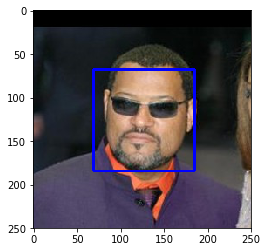

In [11]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [12]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

Answers presented below 

In [13]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

detected_human_humanfile = 0
for face in human_files_short: #simply looping through 100 human faces
    if face_detector(face)==True: #if human face detected, then we'll add 1. Otherwise, nothing added
        detected_human_humanfile=detected_human_humanfile+1
human_wasHuman=str(detected_human_humanfile) 
print(human_wasHuman+"% of the human images have a detected human face")

detected_human_dogfile = 0
for dog in dog_files_short: #simply looping through 100 dog faces
    if face_detector(dog)==True:
        detected_human_dogfile=detected_human_dogfile+1
human_wasDog=str(detected_human_dogfile)
print(human_wasDog+"% of the dog images have a detected human face") 

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


99% of the human images have a detected human face
11% of the dog images have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ 

From the point of view of the user, requiring that a view of the face is "clear" might (at first) seem like an unreasonable request. These potentially annoyed users might argue that generally speaking, a primary goal of deep learning is to accurately mimic tasks performed by humans, such as facial detection. Therefore, they might argue, that because the average person is able to detect faces even when the face is not perfectly clear, this machine should be able to as well! For instance, humans can recognize faces in a variety of "unclear" scenarios: even if they wear glasses that are slightly smudged, or if they view a face that is positioned at an unusual angle, or if a tree branch was blocking their view, they could still discern between a dog and human! If recognizing a face in ANY environment was the goal of this project and deep learning model, then it stands to reason that a "clear face expectation" would diminish our model's practical functionality. 

That said, this "clear face" requirement is a reasonable expectation, considering the stated goals of this assignment. Specifically, our primary goals include 
1. Identifying whether an image is a dog or human
2. Labeling dog breeds (if image is of a dog) 
3. Assigning humans to dog breed categories based on similarities. 

In a practical sense, using unclear faces might overcomplicate the first step of our model. Additionally, similar to how we trained our smartcab in a relatively oversimplified mock-environment, starting with clear faces will help us build a rudimentary yet funcional program that we can eventually improve if necessary. 


In [14]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [16]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [17]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [18]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

Answers presented below

In [22]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_wasHuman = 0
for person in human_files_short: #basically same looping as before, except using new dog_detector function 
    if (dog_detector(person) == True):
        dog_wasHuman=dog_wasHuman+1
        
dog_wasHuman=str(dog_wasHuman)
print (dog_wasHuman+"% of the images that were actually photos of humans detected a dog face")

dog_wasDog = 0
for notperson in dog_files_short:
    if (dog_detector(notperson) == True):
        dog_wasDog=dog_wasDog+1
dog_wasDog=str(dog_wasDog)
print (dog_wasDog+"% of the images that were actually photos of dogs detected a dog face")

1% of the images that were actually photos of humans detected a dog face
100% of the images that were actually photos of dogs detected a dog face


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [23]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True               

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:23<00:00, 35.41it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I used the above example as a framework for building the CNN architecture, but added and adjusted the model in several ways. Overall though, the method of alternating between convolutional layers and maxpooling was effective in 'building up' a visualization for our program (progressing from horizontal or vertical lines in the first layer to more intricate details by the final layer). 

One primary addition was a repeated implementation of dropout regularization (50%) between each step of the process. Over the past months of becoming passionate about deep learning, I've read papers that often suggest and implement 50% regularization as an optimal dropout percentage for a wide range of deep learning problems. 

Additionally, for each of the convolutional layers, I used ReLU activation functions. After conducting some personal research (and after being inspired by some of the videos in the deep learning section), I found that ReLU is effectively the most widely used activation function for most deep learning problems, especially with regard to hidden layers. I also validated padding within each convolutional layer, because I didn't think it would add much time to the calculations, and believed it could only improve our CNN's performance.

We also learned that pool size was an extremely important factor that could determine the efficacy of our model. Similar to how a small batch size (say, of 32) can lead to better results in supervised learning problems at the expense of longer computing time, small pool size enables the maxpoling layers to effectively "learn" more data. Also, maxpooling rather than average pooling has been found to be more effective for many image recognition problems, so I leveraged maxpooling between the convolutional layers. Following the sequence of convolutional layers, maxpooling layers, and dropout regularization, I then flattened the image to prepare it for the dense layers. 

Selecting the number of neurons in the dense layers is far from an exact science, so I used 133 because it represents the number of dog categories (outputs). The dense layers are very similar to the layers we might use in other types of deep learning problems, especially in straightforward supervised learning problems. For instance, I participated in a Kaggle competition (sponsored by Porto Seguro) regarding the probability that customers would get into a car accident or file a claim, and used two deep layers (first using ReLU activation and then applying a softmax to convert into a probability score). I adapted that finishing architecture to this model. These final dense layers of the CNN can be thought of as the truly "black box" elements of deep learning, because we still don't completely understand what makes these dense layers are effective, and can't reverse engineer our predictions to discover which elements are most important. Even though we can't exactly tell how the CNN makes its assessment because of the information in these hidden layers, this final aspect of the architecture helps the CNN learn the more complex relationships between the variables. 


In [228]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture. 
model.add(Conv2D(filters=5, kernel_size=(2,2), strides=1,padding='valid', input_shape=(224,224,3),activation='relu'))
model.add(Dropout(0.5)) 

model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Dropout(0.5))

model.add(Conv2D(filters=5, kernel_size=(2,2), strides=1,padding='valid', activation='relu'))
model.add(Dropout(0.5))

model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
model.add(Dropout(0.5))

model.add(Flatten()) 
model.add(Dense(133, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(133, activation='softmax'))
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 223, 223, 5)       65        
_________________________________________________________________
dropout_156 (Dropout)        (None, 223, 223, 5)       0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 111, 111, 5)       0         
_________________________________________________________________
dropout_157 (Dropout)        (None, 111, 111, 5)       0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 110, 110, 5)       105       
_________________________________________________________________
dropout_158 (Dropout)        (None, 110, 110, 5)       0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 55, 55, 5)         0         
__________

### Compile the Model

In [229]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [231]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs=5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5


6680/6680 [==============================] - 201s 30ms/step - loss: 4.8915 - acc: 0.0078 - val_loss: 4.8834 - val_acc: 0.0132
Epoch 2/5


4080/6680 [=================>............] - ETA: 2:29 - loss: 4.8945 - acc: 0.0000e+0 - ETA: 2:24 - loss: 4.8739 - acc: 0.0250    - ETA: 2:22 - loss: 4.8811 - acc: 0.016 - ETA: 2:20 - loss: 4.8827 - acc: 0.012 - ETA: 2:20 - loss: 4.8802 - acc: 0.010 - ETA: 2:20 - loss: 4.8881 - acc: 0.008 - ETA: 2:20 - loss: 4.8820 - acc: 0.007 - ETA: 2:19 - loss: 4.8740 - acc: 0.012 - ETA: 2:18 - loss: 4.8746 - acc: 0.016 - ETA: 2:17 - loss: 4.8701 - acc: 0.015 - ETA: 2:16 - loss: 4.8725 - acc: 0.018 - ETA: 2:16 - loss: 4.8767 - acc: 0.020 - ETA: 2:15 - loss: 4.8789 - acc: 0.019 - ETA: 2:15 - loss: 4.8755 - acc: 0.021 - ETA: 2:14 - loss: 4.8733 - acc: 0.023 - ETA: 2:14 - loss: 4.8761 - acc: 0.021 - ETA: 2:14 - loss: 4.8746 - acc: 0.020 - ETA: 2:13 - loss: 4.8736 - acc: 0.019 - ETA: 2:13 - loss: 4.8752 - acc: 0.021 - ETA: 2:12 - loss: 4.8753 - acc: 0.020 - ETA: 2:12 - loss: 4.8741 - acc: 0.021 - ETA: 2:12 - loss: 4.8753 - acc: 0.020 - ETA: 2:11 - loss: 4.8751 - acc: 0.021 - ETA: 2:11 - loss: 4.8753 - 

6680/6680 [==============================] - 152s 23ms/step - loss: 4.8762 - acc: 0.0148 - val_loss: 4.8729 - val_acc: 0.0132
Epoch 3/5


6680/6680 [==============================] - 143s 21ms/step - loss: 4.8405 - acc: 0.0190 - val_loss: 4.8636 - val_acc: 0.0108
Epoch 4/5


4100/6680 [=================>............] - ETA: 2:13 - loss: 4.7261 - acc: 0.0000e+0 - ETA: 2:12 - loss: 4.7601 - acc: 0.0000e+0 - ETA: 2:12 - loss: 4.7258 - acc: 0.0500    - ETA: 2:12 - loss: 4.6775 - acc: 0.050 - ETA: 2:12 - loss: 4.6915 - acc: 0.040 - ETA: 2:12 - loss: 4.7150 - acc: 0.033 - ETA: 2:11 - loss: 4.7256 - acc: 0.035 - ETA: 2:11 - loss: 4.7463 - acc: 0.031 - ETA: 2:10 - loss: 4.7472 - acc: 0.027 - ETA: 2:10 - loss: 4.7523 - acc: 0.025 - ETA: 2:09 - loss: 4.7547 - acc: 0.022 - ETA: 2:09 - loss: 4.7588 - acc: 0.020 - ETA: 2:08 - loss: 4.7615 - acc: 0.019 - ETA: 2:08 - loss: 4.7670 - acc: 0.021 - ETA: 2:07 - loss: 4.7615 - acc: 0.023 - ETA: 2:07 - loss: 4.7566 - acc: 0.028 - ETA: 2:06 - loss: 4.7515 - acc: 0.029 - ETA: 2:06 - loss: 4.7505 - acc: 0.030 - ETA: 2:06 - loss: 4.7534 - acc: 0.028 - ETA: 2:05 - loss: 4.7636 - acc: 0.027 - ETA: 2:05 - loss: 4.7597 - acc: 0.028 - ETA: 2:05 - loss: 4.7579 - acc: 0.029 - ETA: 2:05 - loss: 4.7568 - acc: 0.030 - ETA: 2:04 - loss: 4.758

6680/6680 [==============================] - 141s 21ms/step - loss: 4.7931 - acc: 0.0250 - val_loss: 4.8545 - val_acc: 0.0132
Epoch 5/5


6680/6680 [==============================] - 138s 21ms/step - loss: 4.7395 - acc: 0.0293 - val_loss: 4.8283 - val_acc: 0.0180


### Load the Model with the Best Validation Loss

In [233]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [234]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.6316%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [97]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [98]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [99]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [100]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s 813us/step - loss: 12.4617 - acc: 0.1102 - val_loss: 10.8581 - val_acc: 0.2024
Epoch 2/20
6680/6680 [==============================] - 3s 458us/step - loss: 10.3370 - acc: 0.2717 - val_loss: 10.4731 - val_acc: 0.2635
Epoch 3/20
6680/6680 [==============================] - 3s 435us/step - loss: 9.9351 - acc: 0.3313 - val_loss: 9.9983 - val_acc: 0.3126
Epoch 4/20
6680/6680 [==============================] - 3s 419us/step - loss: 9.7509 - acc: 0.3576 - val_loss: 10.1196 - val_acc: 0.3066
Epoch 5/20
6680/6680 [==============================] - 3s 449us/step - loss: 9.6025 - acc: 0.3716 - val_loss: 9.8962 - val_acc: 0.3269
Epoch 6/20
6680/6680 [==============================] - 2s 363us/step - loss: 9.4230 - acc: 0.3847 - val_loss: 9.6497 - val_acc: 0.3198
Epoch 7/20


6680/6680 [==============================] - 3s 486us/step - loss: 9.0266 - acc: 0.4069 - val_loss: 9.4822 - val_acc: 0.3437
Epoch 8/20
6680/6680 [==============================] - 2s 349us/step - loss: 8.8915 - acc: 0.4256 - val_loss: 9.3478 - val_acc: 0.3461
Epoch 9/20
6680/6680 [==============================] - 2s 363us/step - loss: 8.7738 - acc: 0.4328 - val_loss: 9.3093 - val_acc: 0.3605
Epoch 10/20
6680/6680 [==============================] - 3s 405us/step - loss: 8.7175 - acc: 0.4412 - val_loss: 9.2011 - val_acc: 0.3677


Epoch 11/20
6680/6680 [==============================] - 3s 394us/step - loss: 8.5851 - acc: 0.4507 - val_loss: 9.1239 - val_acc: 0.3784
Epoch 12/20
6680/6680 [==============================] - 3s 399us/step - loss: 8.5410 - acc: 0.4579 - val_loss: 9.0861 - val_acc: 0.3749
Epoch 13/20
6680/6680 [==============================] - 3s 382us/step - loss: 8.5032 - acc: 0.4621 - val_loss: 9.0215 - val_acc: 0.3749
Epoch 14/20
6680/6680 [==============================] - 3s 412us/step - loss: 8.4037 - acc: 0.4624 - val_loss: 8.9821 - val_acc: 0.3653
Epoch 15/20
6680/6680 [==============================] - 3s 443us/step - loss: 8.1880 - acc: 0.4760 - val_loss: 8.7043 - val_acc: 0.4000
Epoch 16/20
6680/6680 [==============================] - 3s 509us/step - loss: 7.9806 - acc: 0.4841 - val_loss: 8.5221 - val_acc: 0.4048
Epoch 17/20
6680/6680 [==============================] - 3s 434us/step - loss: 7.7247 - acc: 0.5009 - val_loss: 8.3063 - val_acc: 0.4180
Epoch 18/20


6680/6680 [==============================] - 3s 454us/step - loss: 7.6586 - acc: 0.5121 - val_loss: 8.3942 - val_acc: 0.4072
Epoch 19/20
6680/6680 [==============================] - 3s 497us/step - loss: 7.6333 - acc: 0.5162 - val_loss: 8.2809 - val_acc: 0.4299
Epoch 20/20
6680/6680 [==============================] - 3s 437us/step - loss: 7.5505 - acc: 0.5211 - val_loss: 8.2909 - val_acc: 0.4072


### Load the Model with the Best Validation Loss

In [232]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [102]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.0287%


### Predict Dog Breed with the Model

In [103]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [169]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz') #using xception
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Before creating the architecture below, I researched the four potential pre-trained models that were provided. One study from this year clearly suggested that Xception model produced the most accurate results:

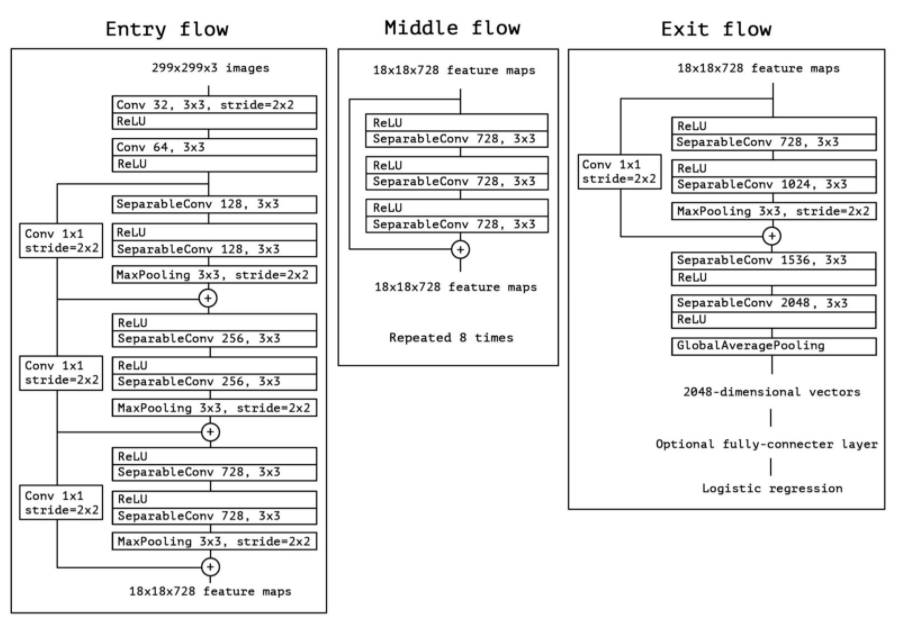https://www.semanticscholar.org/paper/Xception-Deep-Learning-with-Depthwise-Separable-Co-Chollet/02d10918571323cf3f559e66209d2fc3f3c5eac5/figure/1

I used the Xception pre-trained model as a framework for creating this improved CNN architecture. As a result of the utilization of transfer learning, the additional architecture that I created was relatively simple, especially compared to our first relatively innaccurate model. 

I first instantiated the neural network using Sequential. Then, because maxpooling is often preferred over average pooling, I used maxpooling globally. The next two layers exactly mimmicked the first CNN I built: comprised of two dense layers, one with a relu activation and the final with softmax. 

In all, the architecture is simpler because we no longer alternated between the convolutional layers and the maxpooling layers. By using transfer learning, we effectively gained the same knowledge by using the much more complex Xception net's pre-trained images, rather than trying to directly copy its intricate and deep architecture (as shown below, from https://www.kaggle.com/keras/xception). 
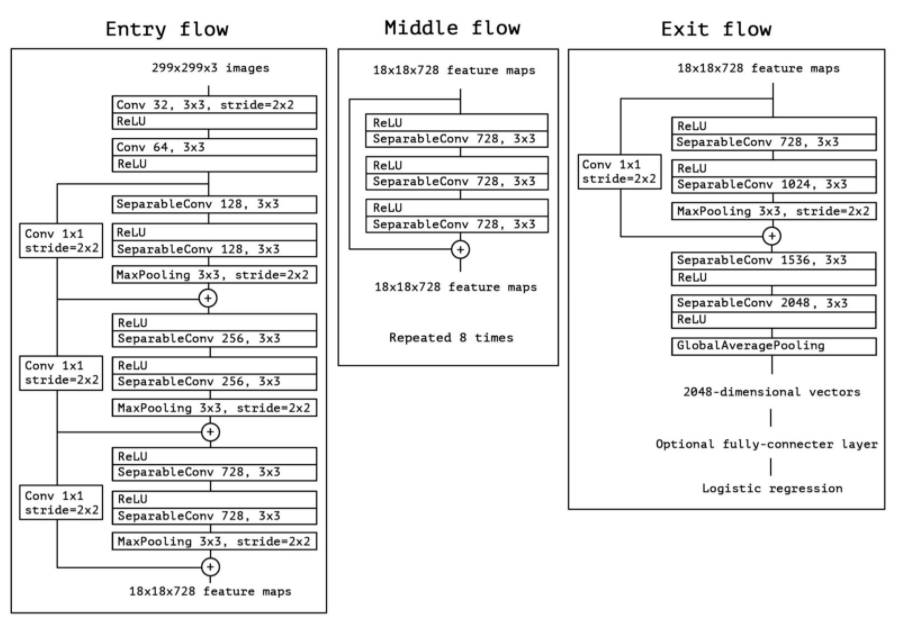 


In [280]:
### TODO: Define your architecture.

from keras.layers import GlobalMaxPooling2D

transfer_Xception = Sequential()
transfer_Xception.add(GlobalMaxPooling2D(input_shape=train_Xception.shape[1:]))

transfer_Xception.add(Dense(133, activation='relu'))
transfer_Xception.add(Dropout(0.5))

transfer_Xception.add(Dense(133, activation='softmax')) #still using softmax because we're still making categorical classifications based on probabilistic estimates 
transfer_Xception.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling2d_10 (Glo (None, 2048)              0         
_________________________________________________________________
dense_108 (Dense)            (None, 133)               272517    
_________________________________________________________________
dropout_169 (Dropout)        (None, 133)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 133)               17822     
Total params: 290,339
Trainable params: 290,339
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [291]:
### TODO: Compile the model.
transfer_Xception.compile(optimizer='sgd', loss='categorical_crossentropy',  metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [292]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.optimal_Xception_3', save_best_only=True)

#print ("train_Xception:", train_Xception.shape, "train_targets:", train_targets.shape)
#print ("valid_Xception:", valid_Xception.shape, "valid_targets:", valid_targets.shape)

transfer_Xception.fit(train_Xception, train_targets, validation_data=(valid_Xception, valid_targets), epochs=10, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - ETA: 23:17 - loss: 0.5983 - acc: 0.81 - ETA: 7:44 - loss: 0.6533 - acc: 0.8021 - ETA: 4:38 - loss: 0.6036 - acc: 0.837 - ETA: 3:18 - loss: 0.6901 - acc: 0.812 - ETA: 2:33 - loss: 0.7022 - acc: 0.805 - ETA: 2:05 - loss: 0.7163 - acc: 0.806 - ETA: 1:38 - loss: 0.6691 - acc: 0.814 - ETA: 1:25 - loss: 0.6421 - acc: 0.814 - ETA: 1:15 - loss: 0.6366 - acc: 0.810 - ETA: 1:08 - loss: 0.6418 - acc: 0.800 - ETA: 1:01 - loss: 0.6347 - acc: 0.799 - ETA: 56s - loss: 0.6380 - acc: 0.803 - ETA: 49s - loss: 0.6364 - acc: 0.79 - ETA: 46s - loss: 0.6247 - acc: 0.79 - ETA: 42s - loss: 0.6247 - acc: 0.79 - ETA: 40s - loss: 0.6307 - acc: 0.79 - ETA: 37s - loss: 0.6354 - acc: 0.79 - ETA: 35s - loss: 0.6406 - acc: 0.79 - ETA: 33s - loss: 0.6520 - acc: 0.79 - ETA: 31s - loss: 0.6601 - acc: 0.79 - ETA: 30s - loss: 0.6493 - acc: 0.79 - ETA: 27s - loss: 0.6441 - acc: 0.79 - ETA: 26s - loss: 0.6433 - acc: 0.79 -

6680/6680 [==============================] - ETA: 4s - loss: 0.6675 - acc: 0.812 - ETA: 4s - loss: 0.6395 - acc: 0.781 - ETA: 4s - loss: 0.6209 - acc: 0.794 - ETA: 4s - loss: 0.5634 - acc: 0.809 - ETA: 4s - loss: 0.5865 - acc: 0.807 - ETA: 4s - loss: 0.5872 - acc: 0.806 - ETA: 3s - loss: 0.5586 - acc: 0.807 - ETA: 3s - loss: 0.5513 - acc: 0.808 - ETA: 3s - loss: 0.5674 - acc: 0.802 - ETA: 3s - loss: 0.5700 - acc: 0.805 - ETA: 3s - loss: 0.5528 - acc: 0.811 - ETA: 3s - loss: 0.5543 - acc: 0.813 - ETA: 3s - loss: 0.5401 - acc: 0.817 - ETA: 3s - loss: 0.5431 - acc: 0.816 - ETA: 3s - loss: 0.5685 - acc: 0.809 - ETA: 3s - loss: 0.5724 - acc: 0.805 - ETA: 3s - loss: 0.5644 - acc: 0.809 - ETA: 3s - loss: 0.5663 - acc: 0.808 - ETA: 3s - loss: 0.5680 - acc: 0.809 - ETA: 3s - loss: 0.5687 - acc: 0.808 - ETA: 3s - loss: 0.5674 - acc: 0.810 - ETA: 3s - loss: 0.5667 - acc: 0.810 - ETA: 2s - loss: 0.5640 - acc: 0.810 - ETA: 2s - loss: 0.5598 - acc: 0.811 - ETA: 2s - loss: 0.5529 - acc: 0.814 - ETA: 

6680/6680 [==============================] - ETA: 4s - loss: 0.4460 - acc: 0.875 - ETA: 4s - loss: 0.3305 - acc: 0.906 - ETA: 4s - loss: 0.3591 - acc: 0.897 - ETA: 4s - loss: 0.3566 - acc: 0.890 - ETA: 4s - loss: 0.3897 - acc: 0.875 - ETA: 4s - loss: 0.4061 - acc: 0.869 - ETA: 4s - loss: 0.4428 - acc: 0.858 - ETA: 3s - loss: 0.4608 - acc: 0.852 - ETA: 3s - loss: 0.4787 - acc: 0.838 - ETA: 3s - loss: 0.4683 - acc: 0.838 - ETA: 3s - loss: 0.4647 - acc: 0.840 - ETA: 3s - loss: 0.4630 - acc: 0.843 - ETA: 3s - loss: 0.4598 - acc: 0.846 - ETA: 3s - loss: 0.4576 - acc: 0.845 - ETA: 3s - loss: 0.4720 - acc: 0.843 - ETA: 3s - loss: 0.4662 - acc: 0.845 - ETA: 3s - loss: 0.4645 - acc: 0.846 - ETA: 3s - loss: 0.4646 - acc: 0.845 - ETA: 3s - loss: 0.4734 - acc: 0.842 - ETA: 3s - loss: 0.4897 - acc: 0.840 - ETA: 3s - loss: 0.4856 - acc: 0.840 - ETA: 3s - loss: 0.4943 - acc: 0.837 - ETA: 2s - loss: 0.5001 - acc: 0.834 - ETA: 2s - loss: 0.5025 - acc: 0.832 - ETA: 2s - loss: 0.5070 - acc: 0.829 - ETA: 

6680/6680 [==============================] - ETA: 4s - loss: 0.5468 - acc: 0.718 - ETA: 4s - loss: 0.5132 - acc: 0.796 - ETA: 4s - loss: 0.4939 - acc: 0.825 - ETA: 4s - loss: 0.5017 - acc: 0.818 - ETA: 4s - loss: 0.4808 - acc: 0.831 - ETA: 4s - loss: 0.4442 - acc: 0.847 - ETA: 3s - loss: 0.4447 - acc: 0.848 - ETA: 3s - loss: 0.4623 - acc: 0.845 - ETA: 3s - loss: 0.4640 - acc: 0.843 - ETA: 3s - loss: 0.4517 - acc: 0.848 - ETA: 3s - loss: 0.4404 - acc: 0.853 - ETA: 3s - loss: 0.4398 - acc: 0.851 - ETA: 3s - loss: 0.4435 - acc: 0.852 - ETA: 3s - loss: 0.4506 - acc: 0.851 - ETA: 3s - loss: 0.4539 - acc: 0.847 - ETA: 3s - loss: 0.4635 - acc: 0.844 - ETA: 3s - loss: 0.4617 - acc: 0.845 - ETA: 3s - loss: 0.4692 - acc: 0.844 - ETA: 3s - loss: 0.4608 - acc: 0.848 - ETA: 3s - loss: 0.4648 - acc: 0.845 - ETA: 3s - loss: 0.4782 - acc: 0.843 - ETA: 3s - loss: 0.4859 - acc: 0.841 - ETA: 2s - loss: 0.4890 - acc: 0.840 - ETA: 2s - loss: 0.4885 - acc: 0.840 - ETA: 2s - loss: 0.4912 - acc: 0.839 - ETA: 

6680/6680 [==============================] - ETA: 4s - loss: 0.7162 - acc: 0.750 - ETA: 4s - loss: 0.6048 - acc: 0.796 - ETA: 4s - loss: 0.5309 - acc: 0.812 - ETA: 4s - loss: 0.5083 - acc: 0.831 - ETA: 4s - loss: 0.4734 - acc: 0.843 - ETA: 4s - loss: 0.4507 - acc: 0.850 - ETA: 4s - loss: 0.4426 - acc: 0.849 - ETA: 4s - loss: 0.4292 - acc: 0.853 - ETA: 4s - loss: 0.4382 - acc: 0.847 - ETA: 4s - loss: 0.4395 - acc: 0.846 - ETA: 4s - loss: 0.4446 - acc: 0.843 - ETA: 4s - loss: 0.4528 - acc: 0.841 - ETA: 4s - loss: 0.4646 - acc: 0.838 - ETA: 4s - loss: 0.4894 - acc: 0.833 - ETA: 3s - loss: 0.4857 - acc: 0.837 - ETA: 3s - loss: 0.4939 - acc: 0.835 - ETA: 3s - loss: 0.4771 - acc: 0.843 - ETA: 3s - loss: 0.4743 - acc: 0.844 - ETA: 3s - loss: 0.4740 - acc: 0.844 - ETA: 3s - loss: 0.4727 - acc: 0.845 - ETA: 3s - loss: 0.4797 - acc: 0.842 - ETA: 3s - loss: 0.4807 - acc: 0.844 - ETA: 3s - loss: 0.4803 - acc: 0.844 - ETA: 3s - loss: 0.4891 - acc: 0.843 - ETA: 3s - loss: 0.4893 - acc: 0.841 - ETA: 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [293]:
### TODO: Load the model weights with the best validation loss.
transfer_Xception.load_weights('saved_models/weights.optimal_Xception_3')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [294]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(transfer_Xception.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
    


# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0144%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [295]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def return_breed(img_path):
    
    bottleneck_feature = extract_Xception(path_to_tensor(img_path)) #1: Extract the bottleneck features (network=Xception)
    
    breed_prediction = transfer_Xception.predict(bottleneck_feature) #2: Supply the bottleneck features as input to the model to return the predicted vector.
    return dog_names[np.argmax(breed_prediction)] #3.  return the corresponding breed


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [296]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def identify_breed(image_link):
    if dog_detector(i)==True:
        breed=str(return_breed(image_link))
        return ("Our system indicates that a dog is in this image! Most likely, this dog is a " +breed)
    else:
        if face_detector(i)==True:
            breed=str(return_breed(image_link))
            return ("Our system tells us that this is a human! The human most closely resembles a "+ breed)
        else:
            return ("Error!! We suspect that you might have included a picture that is neither a dog nor a human.")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The algorithm did about as well as I expected about: it was effective in accurately discerning between humans and dogs, and also correctly identified the dog breed for each of the three dogs. That said, the placements for some of the humans seem rather arbitrary. Even after making only slight changes to the model's architecture or optimizer (say, trying adam optimize), the suggested breeds for humans would change almost every time. This implies that the task of categorizing a human is more of an art than an exact science, because there's no "true" dog breed for each person.  Perhaps better put: it's an unsupervised learning problem that's almost disguised as supervised! 

To improve the algorithm, I would first leverage a technique we learned during the unsupervised learning unit. Specifically: we could use k-means batching, with k=133 to place the human faces into clusters, that could match 1:1 with the dog breeds.

Another way that we could improve our algorithm would be to implement k-nearest neighbor, only when: face_detector(i)==True. Specifically, we would only use the dog images in implementing k-nearest neighbors, such that we might identify k=5 nearest dog images that resemble the given human's image. 

Finally, if we really wanted to spend some time improving our algorithm, we could aggregate user feedback on whether or not they thought the human's suggested dog breed was accurate. In turn, we could use this data to score our assessments. With enough user feedback, we could add a supervised learning element to the problem!

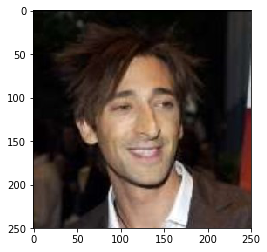

Our system tells us that this is a human! The human most closely resembles a Papillon 



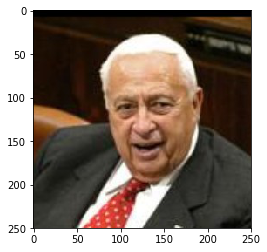

Our system tells us that this is a human! The human most closely resembles a Havanese 



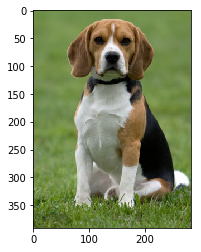

Our system indicates that a dog is in this image! Most likely, this dog is a Beagle 



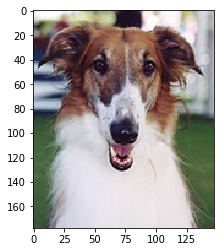

Our system indicates that a dog is in this image! Most likely, this dog is a Borzoi 



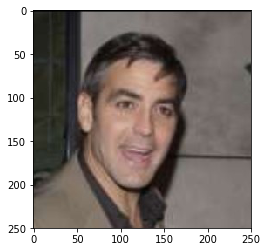

Our system tells us that this is a human! The human most closely resembles a Bichon_frise 



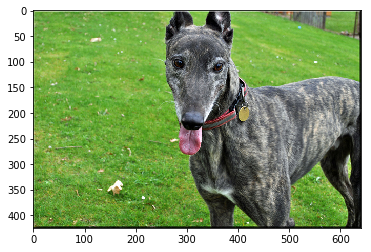

Our system indicates that a dog is in this image! Most likely, this dog is a Greyhound 



In [304]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

samples = ['Adrien_Brody_0001.jpg','Ariel_Sharon_0032.jpg','Beagle_01141.jpg','Borzoi_02183.jpg','George_Clooney_0004.jpg','Greyhound_05517.jpg']

for i in samples:
    img = cv2.imread(i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    print ((identify_breed(i)), '\n')